In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import namedtuple
import copy

import awkward as ak
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import pandas as pd
from rich import print

from particle import Particle

from python.analysis import Master, Plots, cross_section

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


class ThinSlice():
    Slice = namedtuple("Slice", "num pos")

    class Slices(list):
        def __init__(self, width):
            self.width = width

        def __setitem__(self, __index, __value):
            if isinstance(__value, ThinSlice.Slice):
                super().__setitem__(__index, __value)
            else:
                raise TypeError(f"Only {ThinSlice.Slice.__name__} can be added to Slices.")

        def append(self, __value):
            if isinstance(__value, ThinSlice.Slice):
                super().append(__value)
            else:
                raise TypeError(f"Only {ThinSlice.Slice.__name__} can be added to Slices.")

        def insert(self, __index, __value) -> None:
            if isinstance(__value, ThinSlice.Slice):
                super().insert(__index, __value)
            else:
                raise TypeError(f"Only {ThinSlice.Slice.__name__} can be added to Slices.")

        def extend(self, __value) -> None:
            if isinstance(__value, ThinSlice.Slice):
                super().extend(__value)
            else:
                raise TypeError(f"Only Slices can be combined to Slices")

        @property
        def num(self):
            return [ s.num for s in self]

        @property
        def pos(self):
            return [ s.pos for s in self]
        
        def pos_to_num(self, pos):
            slice_num = np.floor(pos//self.width)
            if hasattr(pos, "__iter__"):
                slice_num = ak.values_astype(slice_num, int)
                slice_num = ak.where(pos > max(self.pos), max(self.num), slice_num)
                slice_num = ak.where(pos < 0, min(self.num), slice_num)
            else:
                slice_num = int(slice_num)
                if pos > max(self.pos): 
                    slice_num = max(self.num) # above range go into overflow bin
                if pos < 0:
                    slice_num = min(self.num) # below range go into the upstream loss bin
            return slice_num

        def mean(self, pos : ak.Array, value : ak.Array):
            slice_num = self.pos_to_num(pos)
            mean = np.zeros(len(self), dtype = float)
            
            for s in self.num:
                mean[s + 1] = ak.mean(value[slice_num == s])
            return mean

    @staticmethod
    def CreateThinSlices(min, max, width):
        slices = ThinSlice.Slices(width)

        for i in range(min - (1 * width), max + (2 * width), width):
            slices.append(ThinSlice.Slice(int(i//width), i))
        return slices

    @staticmethod 
    def CrossSection(n_incident : np.array, n_interact : np.array, slice_width : float):
        xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section

        xs_e = 1/(n_incident - n_interact) * ((n_interact**2/n_incident) + n_interact)**0.5

        NA = 6.02214076e23
        factor = 10**27 * cross_section.BetheBloch.A  / (cross_section.BetheBloch.rho * NA * slice_width)

        return factor * xs, factor * xs_e

    @staticmethod
    @Master.timer
    def CountingExperiment(z : ak.Array, region : ak.Array, slices : Slices):
        n_interact = np.zeros(len(slices), dtype = int)
        n_incident = np.zeros(len(slices), dtype = int)

        for j, k in zip(z, region):
            end_slice = slices.pos_to_num(j)

            index = int(end_slice) + 1 # +1 to account for the undeflow bin

            n_incident[0:index+1] += 1 # add 1 to all previous slices and end_slice for n_incident

            if k is True: # only count pion inelastic interactions so charge exchange, absorbtion and pion production
                n_interact[index] += 1 # add 1 to interacting
        return n_incident, n_interact
    
    @staticmethod
    def MeanSliceEnergy(slices : Slices, z : ak.Array, energy : ak.Array):
        return slices.mean(z, energy)


class CrossSections:
    labels = {"abs_KE;1" : "absorption", "inel_KE;1" : "quasielastic", "cex_KE;1" : "charge_exchange", "dcex_KE;1" : "double_charge_exchange", "prod_KE;1" : "pion_produciton", "total_inel_KE;1" : "total_inelastic"}

    def __init__(self, file : str) -> None:
        self.file = uproot.open(file)

        for k in self.file.keys():
            if "total" in k: continue # file is bugged
            if "KE" in k:
                g = self.file[k]
                setattr(self, self.labels[k], g.all_members["fY"])
        self.KE = self.file["abs_KE;1"].all_members["fX"]
        pass

    def __PlotAll(self):
        for k in self.labels.values():
            if "total" in k : continue
            print(k)
            Plots.Plot(self.KE, getattr(self, k), label = k.replace("_", " "), newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$")

    def Plot(self, xs : str):
        if xs == "all":
            self.__PlotAll()
        else:
            Plots.Plot(self.KE, getattr(self, xs), label = xs.replace("_", " "), newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$")


plt.style.use("cyberpunk")
plt.rcParams["figure.dpi"] = 140

#TODO Fix Geant4 simulations so kinetic energy range is 0, 4000
#TODO add error for energy bins
#TODO check what traj_KE actually is and how is it calculated
#? rework mean kinetic energy to estimate the kinetic energy at the start of the thin slice?


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


absorption

quasielastic

charge_exchange

double_charge_exchange

pion_produciton

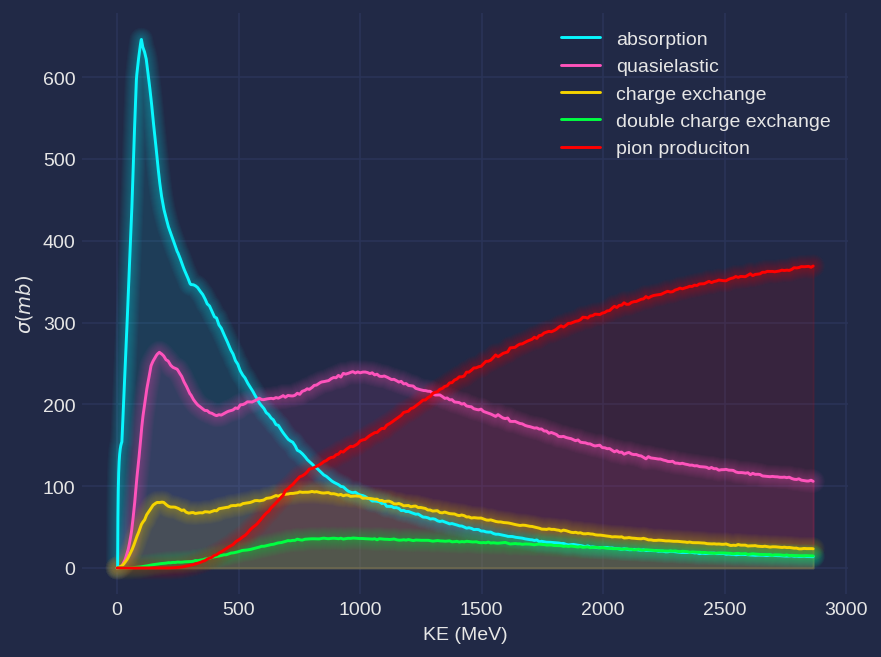

In [15]:
cross_sections = CrossSections("test/g4_xs.root")
cross_sections.Plot("all")
mplcyberpunk.add_glow_effects()


absorption

quasielastic

charge_exchange

double_charge_exchange

pion_produciton

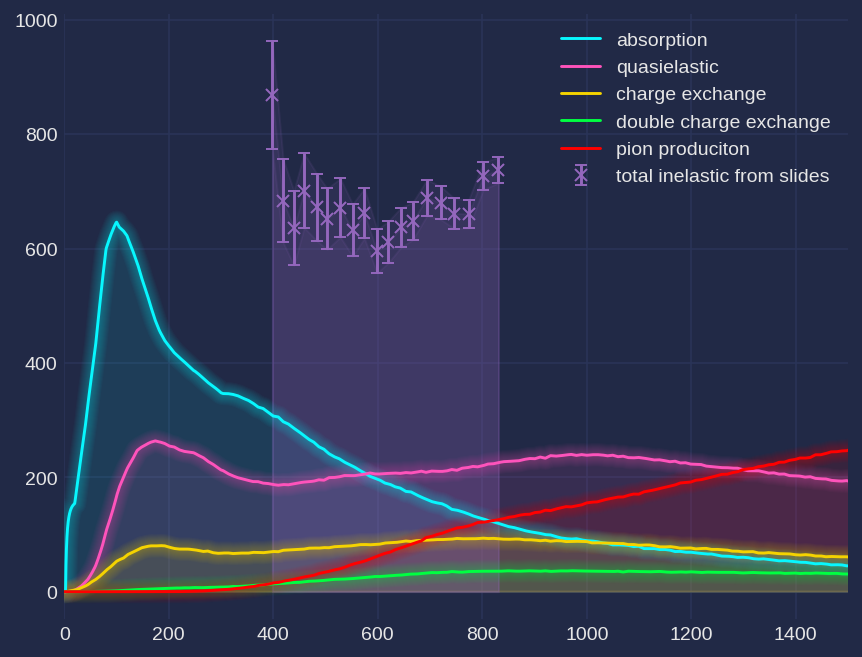

In [7]:
test_energy =   np.array(pd.read_csv("test/energy.csv")[" y"])
test_incident = np.array(pd.read_csv("test/incident.csv")[" y"])
test_interact = np.array(pd.read_csv("test/interact.csv")[" y"])

xs_test = ThinSlice.CrossSection(test_incident, test_interact, 10)
cross_sections.Plot("all")
Plots.Plot(test_energy, xs_test[0], yerr = xs_test[1], marker = "x", linestyle = "", newFigure = False, label = "total inelastic from slides")
plt.xlim(0, 1500)
mplcyberpunk.add_glow_effects()

In [24]:
events = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP, nEvents = 20000)

def AddVariable(name : str):
    events.trueParticles.LoadData(name, name)
    setattr(events.trueParticles, name, getattr(events.trueParticles, f"_TrueParticleData__{name}"))

AddVariable("true_beam_endProcess")
AddVariable("true_beam_traj_Z_SCE")
AddVariable("true_beam_traj_KE")

mask = events.trueParticles.pdg[:, 0] == 211
events.Filter([mask], [mask])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


# Slices based on position

can slice up a TPC into thin slice targets based on the collection wire spacing.

By the conventions used by others, a single slice contains 20 wires, so is 10cm in thinkness (collection plane wire pitch is 5mm)

In [20]:
slices = ThinSlice.CreateThinSlices(0, 230, 10)
print(slices)

[
    Slice(num=-1, pos=-10),
    Slice(num=0, pos=0),
    Slice(num=1, pos=10),
    Slice(num=2, pos=20),
    Slice(num=3, pos=30),
    Slice(num=4, pos=40),
    Slice(num=5, pos=50),
    Slice(num=6, pos=60),
    Slice(num=7, pos=70),
    Slice(num=8, pos=80),
    Slice(num=9, pos=90),
    Slice(num=10, pos=100),
    Slice(num=11, pos=110),
    Slice(num=12, pos=120),
    Slice(num=13, pos=130),
    Slice(num=14, pos=140),
    Slice(num=15, pos=150),
    Slice(num=16, pos=160),
    Slice(num=17, pos=170),
    Slice(num=18, pos=180),
    Slice(num=19, pos=190),
    Slice(num=20, pos=200),
    Slice(num=21, pos=210),
    Slice(num=22, pos=220),
    Slice(num=23, pos=230),
    Slice(num=24, pos=240)
]

Now we do the counting experiment. the cross section in a single slice is:
$$
    \sigma = \frac{M_{Ar}}{\rho t N_{A}}\log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

 - $t$ is the thickness of each slice
 - $N_{incident}$ is the number of incident beam particles in the slice
 - $N_{interact}$ is the number of interacting beam particles in the slice (i.e. the end of the beam particle trajectory)

Alrogithm to count $N_{indicent}$ and $N_{interact}$ is as follows:

 1. Create `N_{indicent}` and `N_{interact}` bins for each slice.
 1. loop over each beam particle and find the end trajectory point
 2. calculate which slice the end trajectory point falls in `end_slice = floor(z/t)`
 3. add 1 to `end_slice` in `N_{interact}` bins and add 1 to every slice before and including `end_slice` in `N_{indicent}` (this makes the assumption the beam particle travelled through every slice before the final one.)


'CountingExperiment' executed in 1.0950s

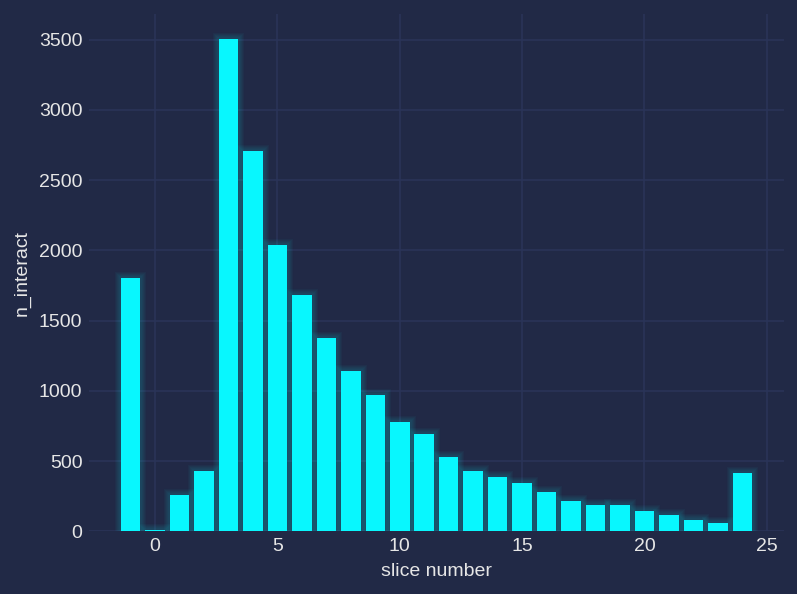

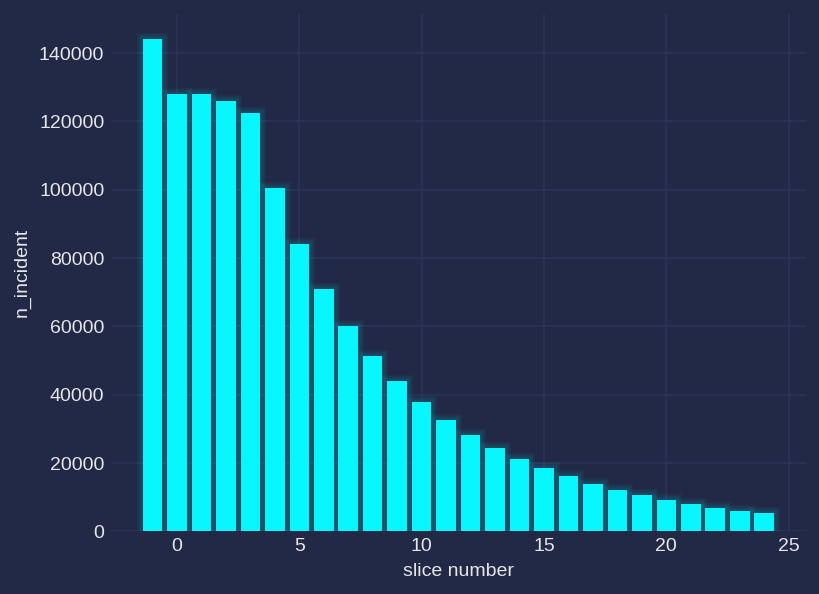

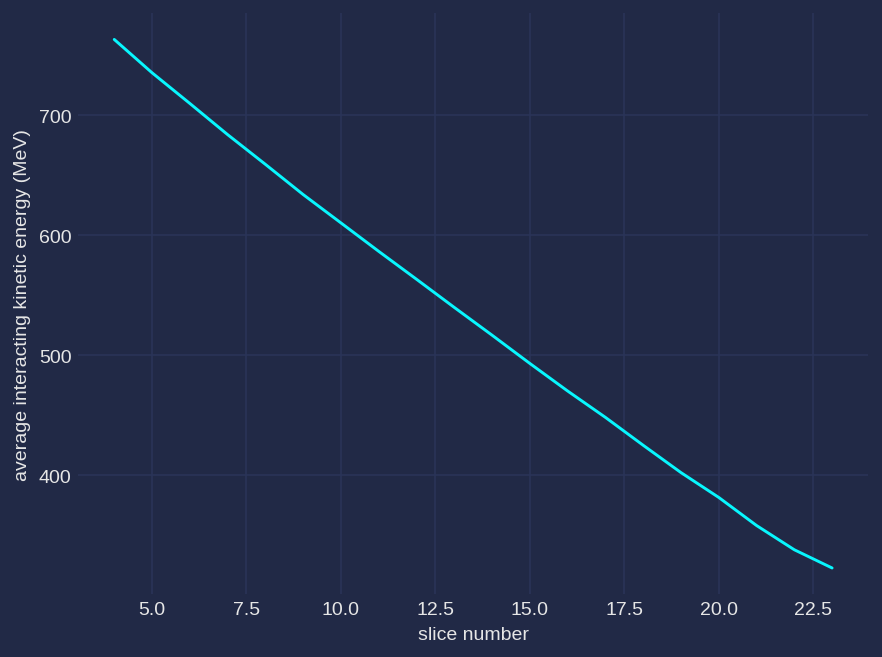

In [21]:
inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
absorption = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0)
cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1)

n_incident, n_interact = ThinSlice.CountingExperiment(events.trueParticles.beam_traj_pos.z[:, -1], inelastic & cex, slices)

#* visualise the histograms
plt.figure()
plt.bar(slices.num, n_interact)
plt.xlabel("slice number")
plt.ylabel("n_interact")
hist_glow()

plt.figure()
plt.bar(slices.num, n_incident)
plt.xlabel("slice number")
plt.ylabel("n_incident")
hist_glow()

n_incident_error = np.sqrt(n_incident)
n_interact_error = np.sqrt(n_interact)

xs = ThinSlice.CrossSection(n_incident, n_interact, slices.width)
mean_slice_energy = ThinSlice.MeanSliceEnergy(slices, events.trueParticles.beam_traj_pos.z, events.trueParticles.true_beam_traj_KE)
Plots.Plot(slices.num[5:-1], (mean_slice_energy)[5:-1], xlabel = "slice number", ylabel = "average interacting kinetic energy (MeV)")


Plot the cross section as a function of slice number

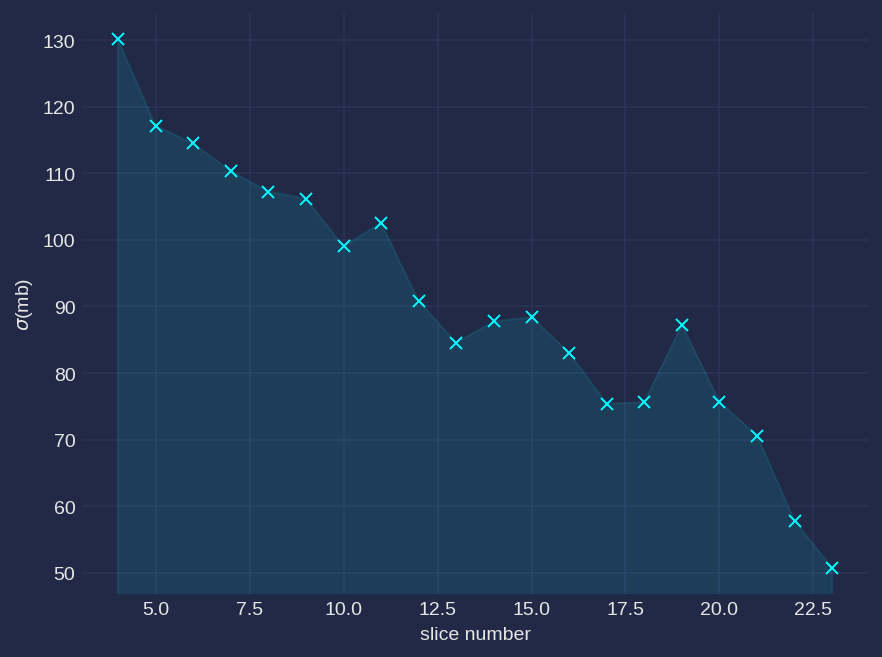

In [22]:
Plots.Plot(slices.num[5:-1], xs[0][5:-1], xlabel = "slice number", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False)
mplcyberpunk.add_glow_effects()

Plot the cross section as a function of the avergae $\pi^{+}$ Kinetic energy in each slice

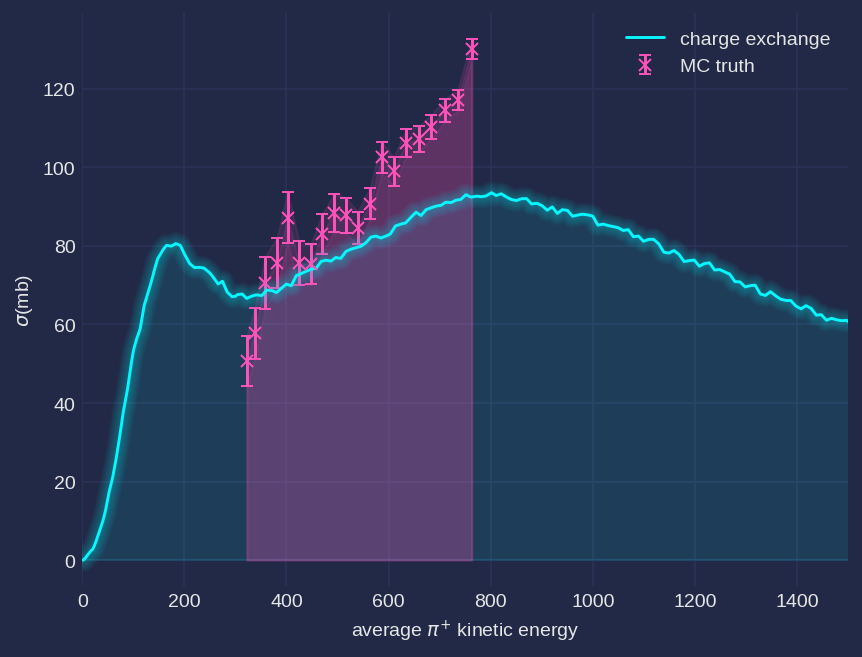

In [23]:
cross_sections.Plot("charge_exchange")
Plots.Plot(mean_slice_energy[5:-1], xs[0][5:-1], yerr = xs[1][5:-1], xlabel = "average $\pi^{+}$ kinetic energy", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
plt.xlim(0, 1500)
mplcyberpunk.add_glow_effects()

# Slices Based on Energy

instead of computing the slices based on the wire pitch, use the energy loss of the particle and define slices in energy instead. This means the slice thickness is now in terms of $\delta E$ and the spacial thickness is:

$$
    t_{i} = \frac{\delta E}{ \left.\frac{dE}{dX}\right|_{E_{i}} }
$$

where i is the slice number, $dE/dX$ is the energy loss per unit length and $E_{i}$ is the particle energy exiting the slice.

i.e. the slice thickness is the distance the particle travels before it looses $\delta E$ worth of energy.

Now the cross section formula becomes:

$$
\sigma_{i} = \frac{M_{Ar}}{\rho N_{A} \delta E} \left.\frac{dE}{dX}\right|_{E_{i}} \log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

And really is a function of the particle kinetic energy rather than the averge kinetic energy in a slice.

By convention, $\delta E$ is set to 50MeV (not sure why) and now the slice thickness need to be calculated per particle

In [29]:
dE = 50 # MeV
plim = 1000 # MeV, depends on the beam aprticle energy you are studying, this is the maximum kinetic energy one could have.

# plim = (plim ** 2 + 135**2)**0.5 - 135

e_slice = np.arange(plim, 0, -dE)
slice_num = np.array(list(reversed(e_slice//dE)))

print(e_slice)
print(slice_num)

[1000  950  900  850  800  750  700  650  600  550  500  450  400  350
  300  250  200  150  100   50]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Now, the counting will work in a similar way, but we can no longer assume the particle travels through all slices because the initial kinetic energy of the beam particle vill vary. So as well as the end slice, an initial slice must be found.

The initial slice is `ceil((plim - KE_ini)//dE)`

The end slice is still the last trajectory point, but the slice number needs to be found based on the energy the particle had before interacting with the target

[762, 637, 824, 922, 261, 194, 759, 377, ... 802, 799, 878, 731, 915, 262, 677, 390]
[800, 931, 889, 929, 949, 806, 852, 844, ... 874, 843, 913, 879, 945, 838, 837, 765]
[4, 1, 2, 1, 1, 3, 2, 3, 1, 1, 1, 3, 1, 3, ... 0, 1, 2, 2, 1, 2, 3, 1, 2, 1, 3, 3, 4]
[4, 7, 3, 1, 14, 16, 4, 12, 1, 3, 5, 12, 4, ... 1, 4, 3, 3, 3, 4, 2, 5, 1, 14, 6, 12]
[0.000e+00 1.997e+03 4.006e+03 4.874e+03 4.140e+03 3.133e+03 2.368e+03
 1.766e+03 1.335e+03 1.015e+03 7.300e+02 5.270e+02 3.590e+02 2.470e+02
 1.690e+02 9.300e+01 4.400e+01 1.300e+01 1.000e+00 0.000e+00]
[0.000e+00 3.010e+02 9.410e+02 1.350e+03 1.430e+03 1.114e+03 7.720e+02
 6.090e+02 4.310e+02 3.220e+02 2.880e+02 2.030e+02 1.690e+02 1.120e+02
 7.800e+01 7.700e+01 5.000e+01 3.100e+01 1.200e+01 1.000e+00]


/tmp/ipykernel_92109/3533149693.py:37: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)
/tmp/ipykernel_92109/3533149693.py:37: RuntimeWarning: divide by zero encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)
/tmp/ipykernel_92109/3533149693.py:37: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)


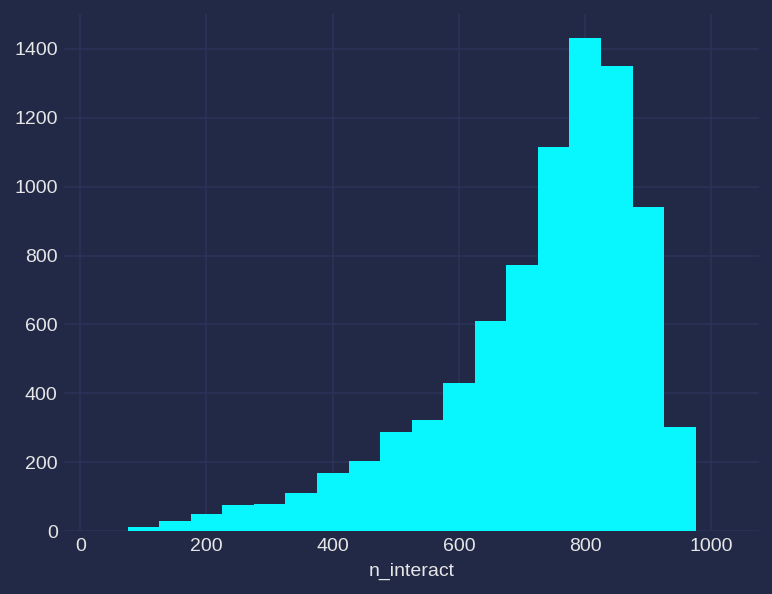

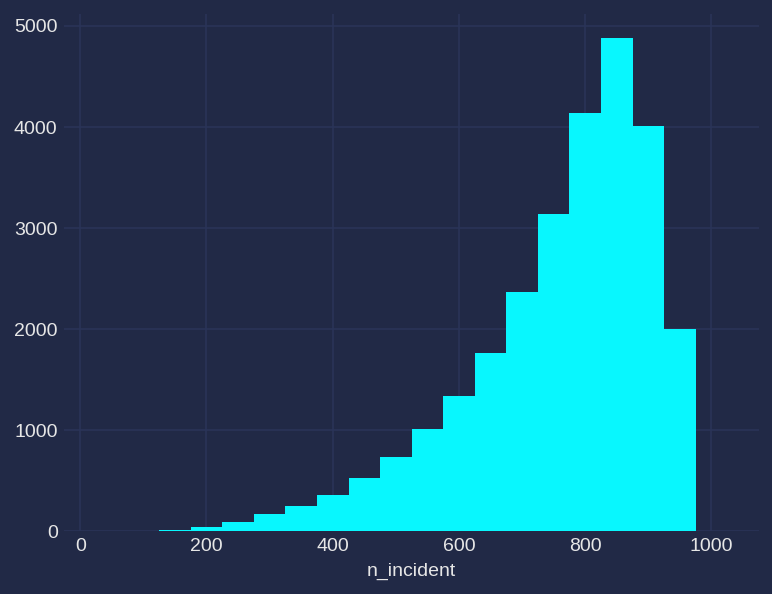

In [30]:
print(events.trueParticles.true_beam_traj_KE[:, -2]) # this is the kinetic energy the particle had before interacting i.e. index -1 is always 0 as it has intercted
print(events.trueParticles.true_beam_traj_KE[:, 0]) # Initial kinetic energy

final_slice = np.floor(plim - events.trueParticles.true_beam_traj_KE[:, -2])//dE
ini_slice = np.ceil(plim - events.trueParticles.true_beam_traj_KE[:, 0])//dE

# ini_slice[ini_slice < 0] = 0
# final_slice[final_slice < 0] = 0

print(ini_slice)
print(final_slice)

n_interact = np.zeros(len(slice_num))
n_incident = np.zeros(len(slice_num))


for i, f, j in zip(ini_slice, final_slice, events.trueParticles.true_beam_endProcess):
    if j == "pi+Inelastic": # only count pion inelastic interactions so charge exchange, absorbtion and pion production
        if i > max(slice_num) or i < min(slice_num): continue
        if f > max(slice_num) or f < min(slice_num): continue

        n_interact[int(f)] += 1
        n_incident[int(i) : int(f)] += 1

print(n_incident)
print(n_interact)

#* visualise the histograms
plt.figure()
plt.bar(e_slice, n_interact, width = 50)
plt.xlabel("n_interact")

plt.figure()
plt.bar(e_slice, n_incident, width = 50)
plt.xlabel("n_incident")

xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section (unit conversion can be done later)

[1000  950  900  850  800  750  700  650  600  550  500  450  400  350
  300  250  200  150  100   50]
[       nan 0.16337352 0.26774567 0.32431825 0.42374715 0.43938867
 0.39454522 0.42288665 0.38985721 0.38161389 0.50173465 0.48645703
 0.63629832 0.60411356 0.61903921 1.76001077        nan        nan
        nan       -inf]


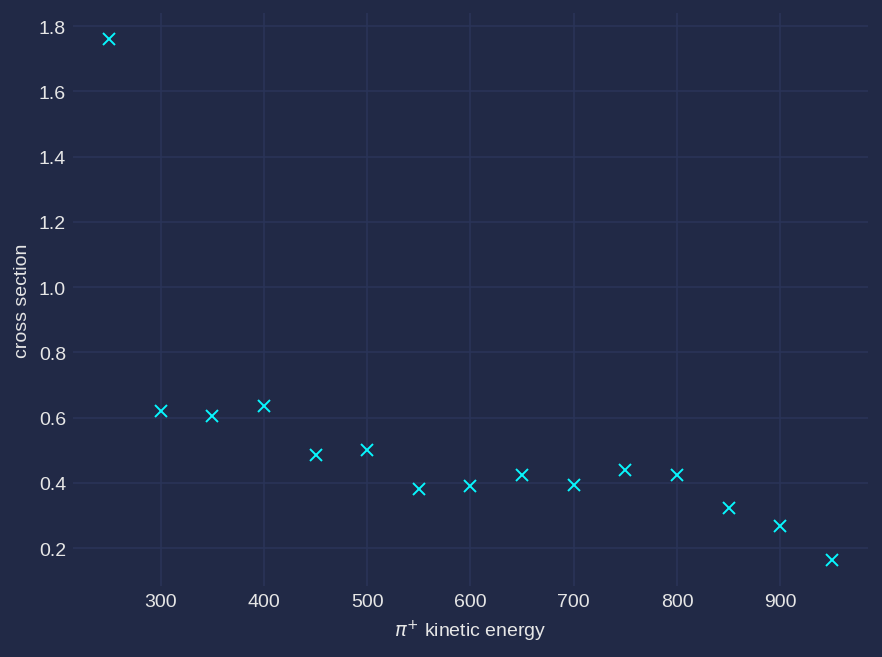

In [31]:
print(e_slice)
print(xs)

Plots.Plot(e_slice, xs, linestyle = "", marker = "x", xlabel = "$\pi^{+}$ kinetic energy", ylabel = "cross section")

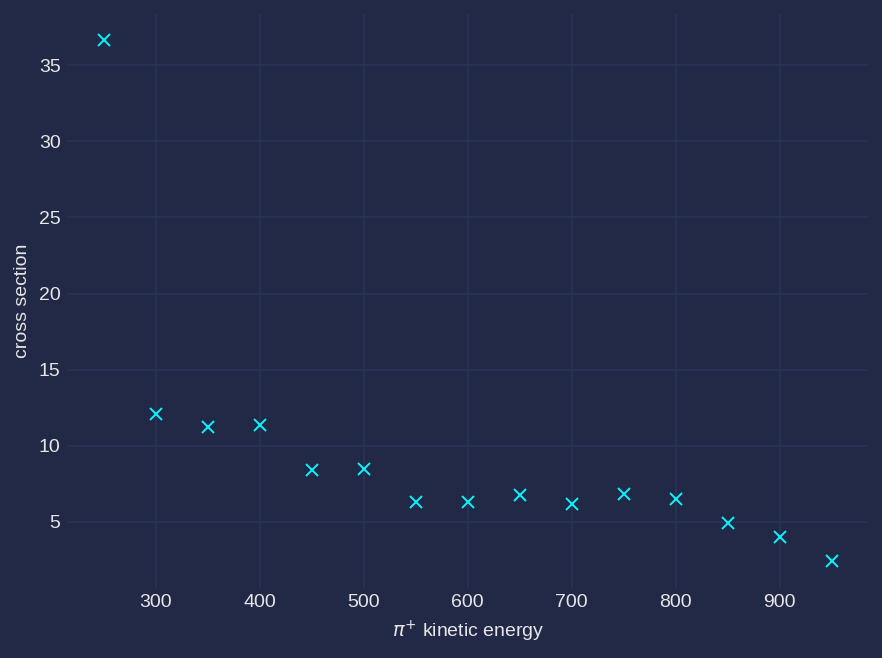

In [39]:
factor = 10**27 *  A / (rho * NA * dE) * np.array([ cross_section.BetheBloch.meandEdX(e - 25, Particle.from_pdgid(211)) for e in e_slice])
# slice_thickness = np.array([meandEdX(e - 25, pip_mass) for e in e_slice]) / dE
# print(slice_thickness)
Plots.Plot(e_slice, xs * factor, linestyle = "", marker = "x", xlabel = "$\pi^{+}$ kinetic energy", ylabel = "cross section")


Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$

### Old notes
Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$